In [21]:
import torch
from torch import nn

# my failedattempt at alexnet! 
try:

    net_fail =  nn.Sequential( 
        nn.Conv2d(3 * 224 * 224, 96, kernel_size=11, stride=4),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(96, 256, kernel_size=5, padding=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(256, 384, kernel_size=3, padding=1),
        nn.Conv2d(384, 384, kernel_size=3, padding=1),
        nn.Conv2d(384, 384, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=3,stride=2),
        nn.Linear(384, 4096),
        nn.Linear(4096, 4096),
        nn.Linear(4096,1000)
    )
except Exception as e:
    print(e)

[enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6994132992 bytes.


In [22]:
X = torch.randn((3,224,224))

In [23]:
try:
    net_fail(X)
except Exception as e:
    print(e)

Expected 4-dimensional input for 4-dimensional weight [96, 150528, 11, 11], but got 3-dimensional input of size [3, 224, 224] instead


In [24]:
alex_net = nn.Sequential( 
            # we use kernel size 11 to capture large features
            nn.Conv2d(1,96,kernel_size=11, stride=4, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # making the convolutional window smaller here but we increase output size
            nn.Conv2d(96, 256,kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Use three successive convolutional layers and a smaller convolution
            # window. Except for the final convolutional layer, the number of output
            # channels is further increased. Pooling layers are not used to reduce the
            # height and width of input after the first two convolutional layers
    
            nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    
            # Here the number of output is isseveraltimes larger than lenet so we need to incorporate dropout
            nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
)

In [25]:
X = torch.randn(1,1,224,224)
X.shape

torch.Size([1, 1, 224, 224])

In [26]:
for layer in alex_net:
    X = layer(X)
    print(f"{layer.__class__.__name__} shape : {X.shape}")

Conv2d shape : torch.Size([1, 96, 54, 54])
ReLU shape : torch.Size([1, 96, 54, 54])
MaxPool2d shape : torch.Size([1, 96, 26, 26])
Conv2d shape : torch.Size([1, 256, 26, 26])
ReLU shape : torch.Size([1, 256, 26, 26])
MaxPool2d shape : torch.Size([1, 256, 12, 12])
Conv2d shape : torch.Size([1, 384, 12, 12])
ReLU shape : torch.Size([1, 384, 12, 12])
Conv2d shape : torch.Size([1, 384, 12, 12])
ReLU shape : torch.Size([1, 384, 12, 12])
Conv2d shape : torch.Size([1, 256, 12, 12])
ReLU shape : torch.Size([1, 256, 12, 12])
MaxPool2d shape : torch.Size([1, 256, 5, 5])
Flatten shape : torch.Size([1, 6400])
Linear shape : torch.Size([1, 4096])
ReLU shape : torch.Size([1, 4096])
Dropout shape : torch.Size([1, 4096])
Linear shape : torch.Size([1, 4096])
ReLU shape : torch.Size([1, 4096])
Dropout shape : torch.Size([1, 4096])
Linear shape : torch.Size([1, 10])


In [27]:
# Reading the dataset
batch_size = 128

# we will be resizing the dataset offashion mnist so that it fits alex nets

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets


my_transforms = transforms.Compose(
                [transforms.Resize((224, 224)),
                transforms.ToTensor()]
)

train_dataset = datasets.FashionMNIST(download=False,root="../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../data", train=False, transform=my_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [28]:
for X, y in train_dataloader:
    break

X.shape, len(y)

(torch.Size([128, 1, 224, 224]), 128)

tensor(8)


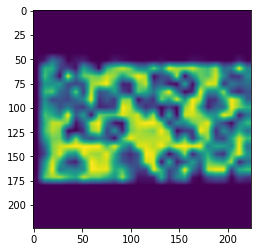

In [29]:
import matplotlib.pyplot as plt

print(y[0])
plt.imshow(X[0].permute(1,2,0))

In [30]:
def accuracy(y_hat, y):
    return (y_hat.argmax(1) == y).sum()

In [31]:
def evaluate_accuracy_gpu(net, data_iter):
    if isinstance(net, nn.Module):
        net.eval()
    device = torch.device('cuda')
    
    acc_arr = 0
    total_number = 0
    
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device).float()
            y = y.to(device).float()
            net = net.to(device)
            y_hat = net(X)
            acc_arr += accuracy(y_hat, y)
            total_number += y.numel()

    return acc_arr/total_number
        

In [32]:
from torch import nn


def train_ch7(net, train_iter, test_iter, num_epochs, lr, device=torch.device('cuda')):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    
    net.apply(init_weights)
    
    print(f'training on device : {device}')
    
    net = net.to(device)
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for epoch in range(num_epochs):
        current_l = 0
        current_numer = 0
        current_acc = 0
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            
            X = X.float()
            y = y.long()
            
            y_hat = net(X)
            l = loss_criterion(y_hat, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            current_l += l
            current_numer += X.shape[0]
            current_acc += accuracy(y_hat, y)
            
        print(f'\nFor epoch {epoch} the loss {current_acc/ current_numer}')
        
        with torch.no_grad():
            
            print("\tStatistics:")
            print(f'\tcurrent train loss : {float(current_l/current_numer)}')
            print(f'\tcurrent train acc : {float(current_acc/current_numer)}')
            print(f'\tcurrent test acc : {float(evaluate_accuracy_gpu(net, test_iter))}')
    
            train_loss.append(float(current_l/current_numer))
            train_acc.append(float(current_acc/current_numer))
            test_acc.append(float(evaluate_accuracy_gpu(net, test_iter)))
    
    with torch.no_grad():
        print(len(train_loss), len(train_acc), len(test_acc))
        print(type(train_loss), type(train_acc), type(test_acc))
        plt.plot(range(num_epochs), train_loss)
        plt.plot(range(num_epochs), train_acc)
        plt.plot(range(num_epochs), test_acc)
        plt.grid(True)
        plt.show()
            
            

training on device : cuda

For epoch 0 the loss 0.09943333268165588
	Statistics:
	current train loss : 38.27983856201172
	current train acc : 0.09943333268165588
	current test acc : 0.09999999403953552

For epoch 1 the loss 0.09915000200271606
	Statistics:
	current train loss : 0.01800302229821682
	current train acc : 0.09915000200271606
	current test acc : 0.09999999403953552

For epoch 2 the loss 0.09915000200271606
	Statistics:
	current train loss : 0.018002724274992943
	current train acc : 0.09915000200271606
	current test acc : 0.09999999403953552

For epoch 3 the loss 0.09714999794960022
	Statistics:
	current train loss : 0.018004391342401505
	current train acc : 0.09714999794960022
	current test acc : 0.09999999403953552

For epoch 4 the loss 0.09809999912977219
	Statistics:
	current train loss : 0.018004335463047028
	current train acc : 0.09809999912977219
	current test acc : 0.09999999403953552

For epoch 5 the loss 0.09853333234786987
	Statistics:
	current train loss : 0.0180

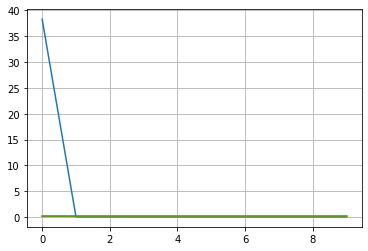

Wall time: 30min 5s


In [33]:
%%time
lr , num_epochs = 0.01, 10
train_ch7(alex_net, train_dataloader, test_dataloader, num_epochs, lr)